# Convolutional Neural Network
In this notebook I will train a Convolutional Neural Network for classification of erosion.

In [1]:
# Adjust the frac parameter for loess smoothing
# to control the degree of smoothing applied to the scan data.
labeled_dir = "../../scandata/cnn_slices loess frac=0.18_labeled"

masks_path = "../stratified_k-fold_masks.npy"

DetectionNotClassification = False  # Set to True to replace all non-zero labels with 1

Libraries used:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)

from sklearn.preprocessing import StandardScaler

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Use GPU if available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

2025-08-19 00:25:55.253324: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-19 00:25:55.269336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755563155.281520   99362 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755563155.285257   99362 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755563155.295261   99362 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Num GPUs Available: 1
TensorFlow version: 2.19.0


In [3]:
all_masks = np.load(masks_path, allow_pickle=True)

# List all labeled files
labeled_files = [f for f in os.listdir(labeled_dir) if f.endswith("_cnn_slices_labeled.npy")]
selected_files = labeled_files  # Use all files by default

In [4]:
# Load features (X) and labels (y) for each file
all_X = []
all_y = []
for labeled_file in selected_files:
    data = np.load(os.path.join(labeled_dir, labeled_file), allow_pickle=True).item()
    slices = data["slices"]  # shape: (num_slices, height, width)
    labels = data["labels"]  # shape: (num_slices,)

    # Add channel dimension for CNN: (num_slices, height, width, 1)
    X = np.expand_dims(slices, axis=-1)
    if DetectionNotClassification:
        y = (labels != 0).astype(int)
    else:
        y = labels  # keep original labels for multiclass
    all_X.append(X)
    all_y.append(y)
    print(f"Loaded {labeled_file}: X shape {X.shape}, y shape {y.shape}")

Loaded 221111_144114__binary_onlylines114378to117271 loess frac=0.18_difference_cnn_slices_labeled.npy: X shape (290, 654, 10, 1), y shape (290,)
Loaded 221111_144114__binary_onlylines145900to148050 loess frac=0.18_difference_cnn_slices_labeled.npy: X shape (216, 654, 10, 1), y shape (216,)
Loaded 221111_144114__binary_onlylines25660to28100 loess frac=0.18_difference_cnn_slices_labeled.npy: X shape (245, 654, 10, 1), y shape (245,)
Loaded 221111_144114__binary_onlylines47178to50517 loess frac=0.18_difference_cnn_slices_labeled.npy: X shape (334, 654, 10, 1), y shape (334,)
Loaded 221111_144114__binary_onlylines86841to90142 loess frac=0.18_difference_cnn_slices_labeled.npy: X shape (331, 654, 10, 1), y shape (331,)


I0000 00:00:1755563158.255964   99362 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Training File 0, Fold 0
Train shape: (232, 654, 10, 1), Val shape: (58, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100


I0000 00:00:1755563159.805390   99528 service.cc:152] XLA service 0x760af000cfa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755563159.805418   99528 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-08-19 00:25:59.836547: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755563159.943737   99528 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/8 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.2500 - auc: 0.4419 - loss: 1.1156 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1755563163.372530   99528 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 655ms/step - accuracy: 0.3855 - auc: 0.5657 - loss: 1.0870 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6379 - val_auc: 0.7284 - val_loss: 1.0504 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6570 - auc: 0.7615 - loss: 0.9704 - precision: 0.5677 - recall: 0.1088 - val_accuracy: 0.6379 - val_auc: 0.7241 - val_loss: 0.9500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6625 - auc: 0.7293 - loss: 0.9173 - precision: 0.6430 - recall: 0.5630 - val_accuracy: 0.6379 - val_auc: 0.7328 - val_loss: 0.9291 - val_precision: 0.6379 - val_recall: 0.6379
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6422 - auc: 0.7220 - loss: 0.9317 - precision: 0.6328 - recall: 0.5768 - val_accuracy: 0.6379 - val_auc: 0.7328 - val_loss: 0.9336 - val_precision: 0.6379 - val_recall: 0.6379
Epoch 5/100
8/8 ━━━━━━━━━━━

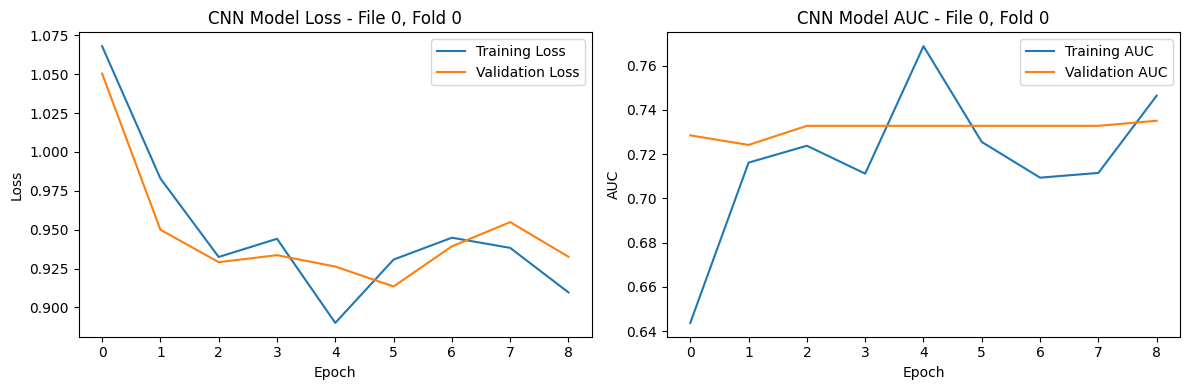

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Training File 0, Fold 1
Train shape: (232, 654, 10, 1), Val shape: (58, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step - accuracy: 0.5878 - auc: 0.7321 - loss: 0.9677 - precision: 0.7086 - recall: 0.2451 - val_accuracy: 0.6379 - val_auc: 0.7328 - val_loss: 0.9136 - val_precision: 0.6379 - val_recall: 0.6379
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6449 - auc: 0.7425 - loss: 0.9232 - precision: 0.6647 - recall: 0.6103 - val_accuracy: 0.6379 - val_auc: 0.7328 - val_loss: 0.9137 - val_precision: 0.6379 - val_recall: 0.6379
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6637 - auc: 0.7438 - loss: 0.9091 - precision: 0.6671 - recall: 0.6122 - val_accuracy: 0.6379 - val_auc: 0.7328 - val_loss: 0.9577 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6694 - auc: 0.7500 - loss: 0.9060 - precision: 0.6817 - reca

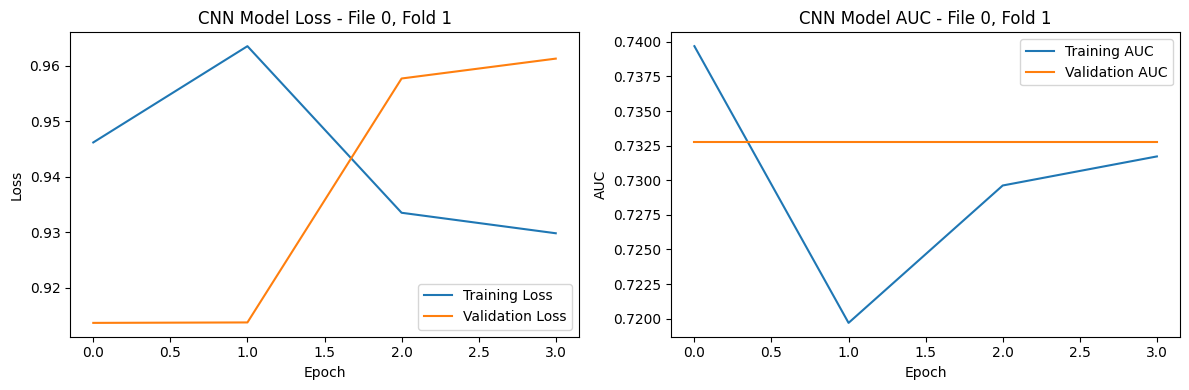

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step
Training File 0, Fold 2
Train shape: (232, 654, 10, 1), Val shape: (58, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 522ms/step - accuracy: 0.4279 - auc: 0.5532 - loss: 1.0905 - precision: 0.3426 - recall: 0.0059 - val_accuracy: 0.6379 - val_auc: 0.7319 - val_loss: 1.0028 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6232 - auc: 0.6866 - loss: 0.9812 - precision: 0.5764 - recall: 0.3246 - val_accuracy: 0.6379 - val_auc: 0.7312 - val_loss: 0.9295 - val_precision: 0.6379 - val_recall: 0.6379
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6212 - auc: 0.7207 - loss: 0.9471 - precision: 0.6288 - recall: 0.5852 - val_accuracy: 0.6379 - val_auc: 0.7319 - val_loss: 0.9247 - val_precision: 0.6379 - val_recall: 0.6379
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6249 - auc: 0.7395 - loss: 0.9212 - precision: 0.6363 - reca

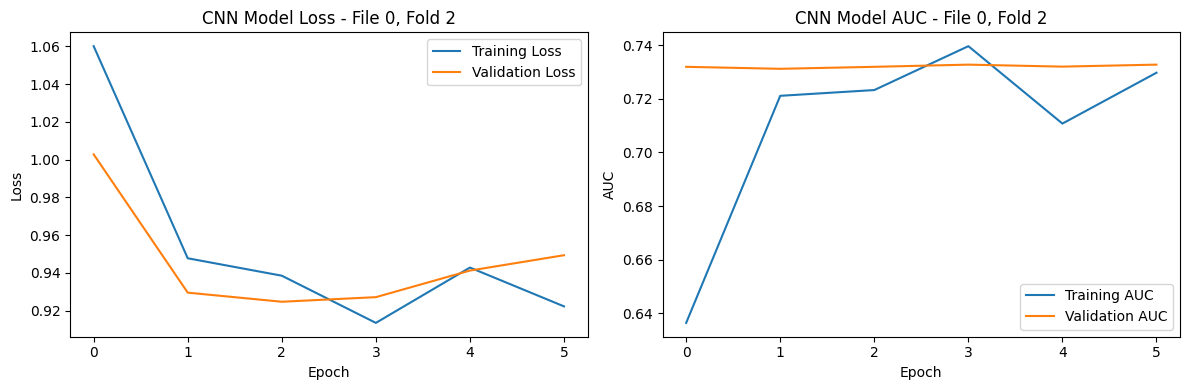

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x760b982b7b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Training File 0, Fold 3
Train shape: (232, 654, 10, 1), Val shape: (58, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 485ms/step - accuracy: 0.2819 - auc: 0.4327 - loss: 1

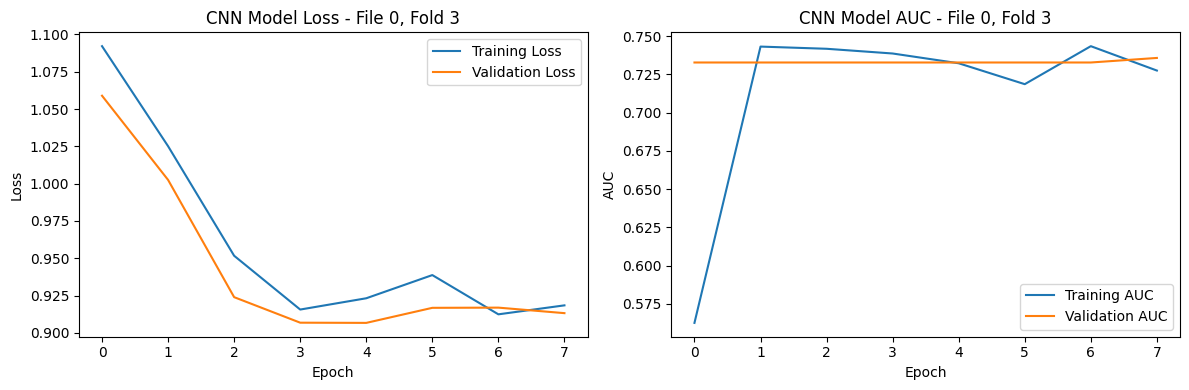

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Training File 0, Fold 4
Train shape: (232, 654, 10, 1), Val shape: (58, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 524ms/step - accuracy: 0.2900 - auc: 0.5000 - loss: 1.1018 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6379 - val_auc: 0.7241 - val_loss: 1.0358 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6262 - auc: 0.7059 - loss: 1.0063 - precision: 0.5251 - recall: 0.0951 - val_accuracy: 0.6379 - val_auc: 0.7241 - val_loss: 0.9615 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6409 - auc: 0.7306 - loss: 0.9434 - precision: 0.6307 - recall: 0.4858 - val_accuracy: 0.6379 - val_auc: 0.7241 - val_loss: 0.9217 - val_precision: 0.6379 - val_recall: 0.6379
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6327 - auc: 0.7355 - loss: 0.9346 - precisio

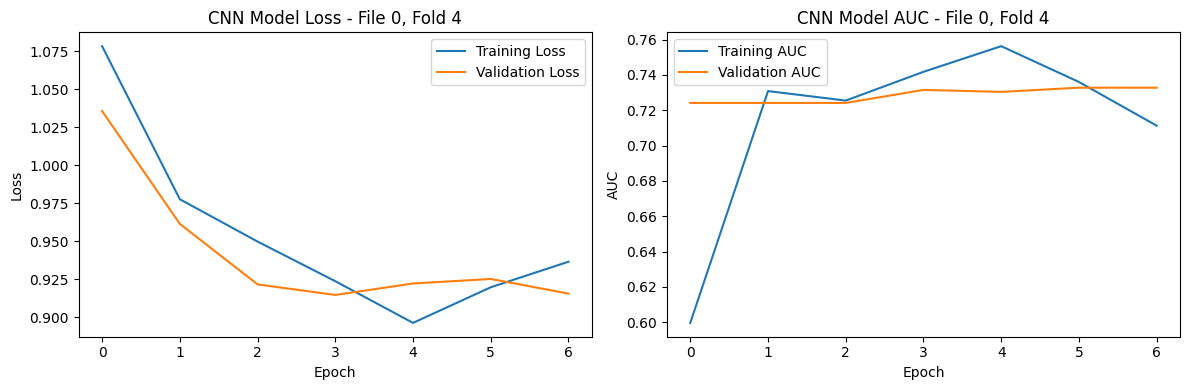

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
Training File 1, Fold 0
Train shape: (172, 654, 10, 1), Val shape: (44, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 907ms/step - accuracy: 0.5504 - auc: 0.6999 - loss: 1.0339 - precision: 0.5714 - recall: 0.0205 - val_accuracy: 0.7045 - val_auc: 0.7614 - val_loss: 0.9571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6922 - auc: 0.7541 - loss: 0.8977 - precision: 0.6903 - recall: 0.4933 - val_accuracy: 0.7045 - val_auc: 0.7546 - val_loss: 0.8534 - val_precision: 0.7045 - val_recall: 0.7045
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7232 - auc: 0.7957 - loss: 0.8125 - precision: 0.7220 - recall: 0.7121 - val_accuracy: 0.7045 - val_auc: 0.7784 - val_loss: 0.8196 - val_precision: 0.7045 - val_recall: 0.7045
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6804 - auc: 0.7714 - loss: 0.8890 - precision: 0.6781 - reca

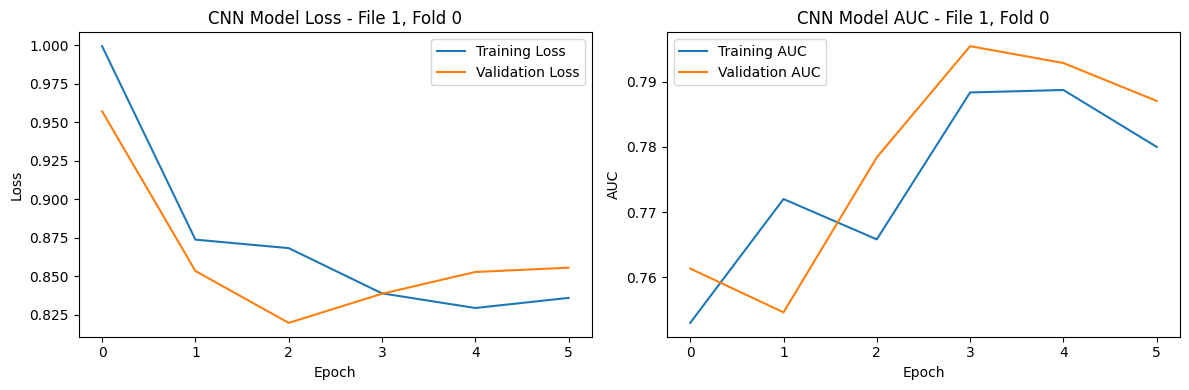

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Training File 1, Fold 1
Train shape: (173, 654, 10, 1), Val shape: (43, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 933ms/step - accuracy: 0.1924 - auc: 0.3140 - loss: 1.2250 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7209 - val_auc: 0.7791 - val_loss: 1.0208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6646 - auc: 0.7461 - loss: 0.9789 - precision: 0.6849 - recall: 0.1352 - val_accuracy: 0.7209 - val_auc: 0.7791 - val_loss: 0.9234 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6805 - auc: 0.7657 - loss: 0.9074 - precision: 0.7030 - recall: 0.4431 - val_accuracy: 0.7209 - val_auc: 0.7791 - val_loss: 0.8517 - val_precision: 0.7209 - val_recall: 0.7209
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7163 - auc: 0.7576 - loss: 0.8682 - precisio

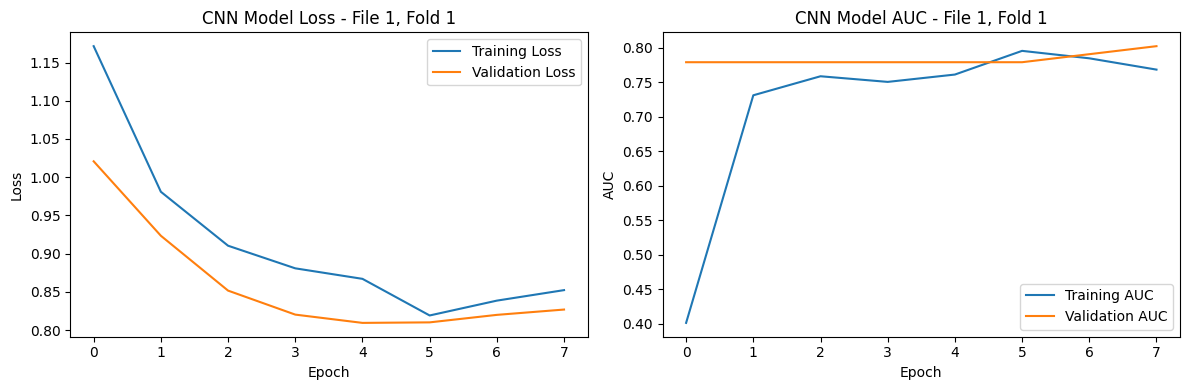

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Training File 1, Fold 2
Train shape: (173, 654, 10, 1), Val shape: (43, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 680ms/step - accuracy: 0.2330 - auc: 0.3316 - loss: 1.1586 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6977 - val_auc: 0.7791 - val_loss: 1.0592 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6614 - auc: 0.7660 - loss: 1.0240 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6977 - val_auc: 0.7791 - val_loss: 0.9902 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7080 - auc: 0.7903 - loss: 0.9392 - precision: 0.8575 - recall: 0.1330 - val_accuracy: 0.6977 - val_auc: 0.7758 - val_loss: 0.9009 - val_precision: 0.6977 - val_recall: 0.6977
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7044 - auc: 0.7711 - loss: 0.8707 - 

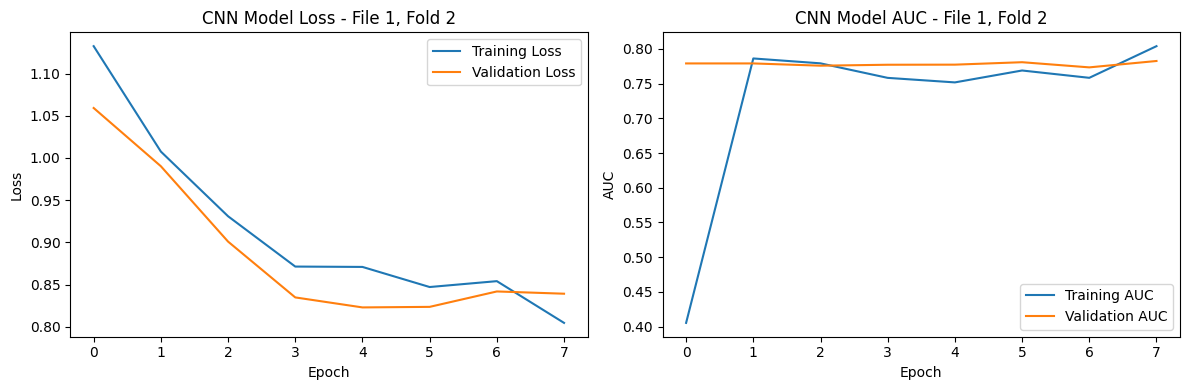

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Training File 1, Fold 3
Train shape: (173, 654, 10, 1), Val shape: (43, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 677ms/step - accuracy: 0.5095 - auc: 0.6707 - loss: 1.0424 - precision: 0.2286 - recall: 0.0066 - val_accuracy: 0.6977 - val_auc: 0.7689 - val_loss: 0.9607 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6968 - auc: 0.7940 - loss: 0.8925 - precision: 0.7332 - recall: 0.3672 - val_accuracy: 0.6977 - val_auc: 0.7791 - val_loss: 0.8556 - val_precision: 0.6977 - val_recall: 0.6977
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6825 - auc: 0.7642 - loss: 0.8823 - precision: 0.6893 - recall: 0.6257 - val_accuracy: 0.6977 - val_auc: 0.7700 - val_loss: 0.8285 - val_precision: 0.6977 - val_recall: 0.6977
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7382 - auc: 0.7859 - loss: 0.8236 - precision: 0.7278 - reca

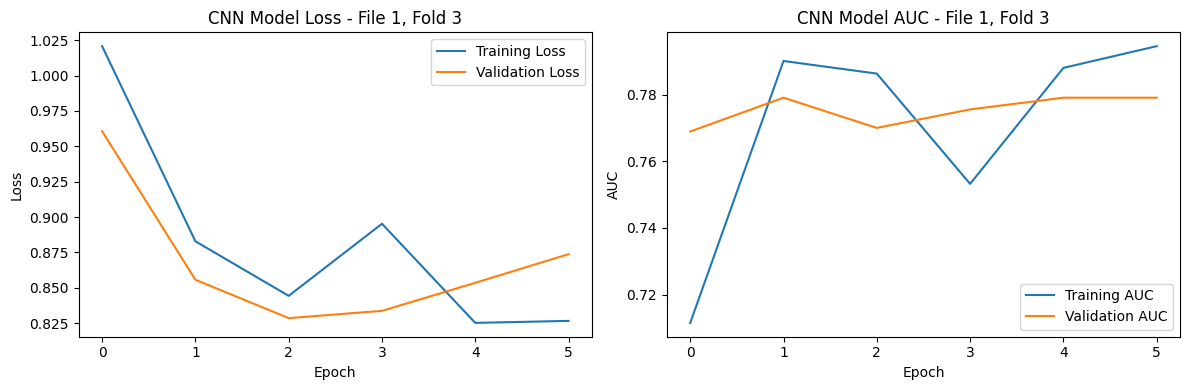

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Training File 1, Fold 4
Train shape: (173, 654, 10, 1), Val shape: (43, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 667ms/step - accuracy: 0.4217 - auc: 0.5894 - loss: 1.0761 - precision: 0.1633 - recall: 0.0066 - val_accuracy: 0.6977 - val_auc: 0.7791 - val_loss: 0.9796 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7227 - auc: 0.7818 - loss: 0.9046 - precision: 0.6318 - recall: 0.3321 - val_accuracy: 0.6977 - val_auc: 0.7791 - val_loss: 0.8620 - val_precision: 0.6977 - val_recall: 0.6977
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7015 - auc: 0.7737 - loss: 0.8543 - precision: 0.6864 - recall: 0.6375 - val_accuracy: 0.6977 - val_auc: 0.7791 - val_loss: 0.8283 - val_precision: 0.6977 - val_recall: 0.6977
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7263 - auc: 0.7925 - loss: 0.8139 - precision: 0.7192 - reca

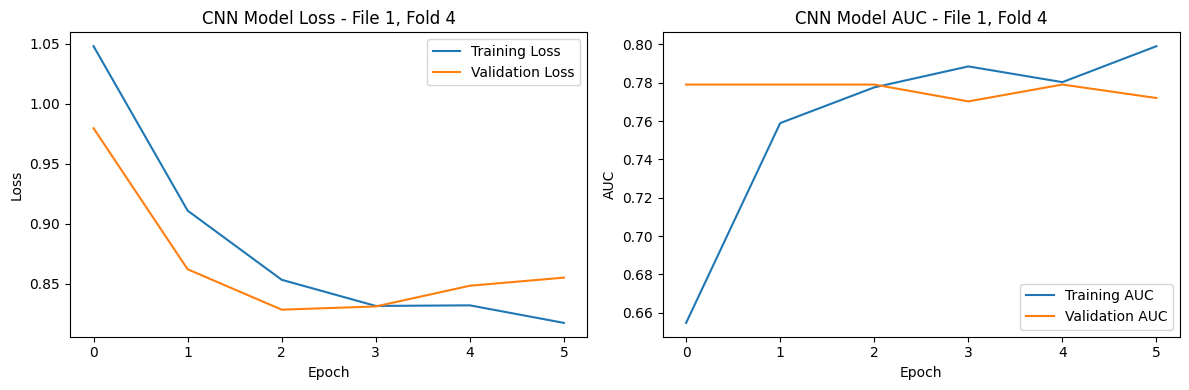

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Training File 2, Fold 0
Train shape: (196, 654, 10, 1), Val shape: (49, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 893ms/step - accuracy: 0.2733 - auc: 0.3930 - loss: 1.2025 - precision: 0.1806 - recall: 0.0155 - val_accuracy: 0.6939 - val_auc: 0.7755 - val_loss: 0.9973 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5724 - auc: 0.7086 - loss: 0.9939 - precision: 0.6168 - recall: 0.1867 - val_accuracy: 0.6939 - val_auc: 0.7653 - val_loss: 0.9317 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7024 - auc: 0.7624 - loss: 0.9071 - precision: 0.6861 - recall: 0.4395 - val_accuracy: 0.6939 - val_auc: 0.7770 - val_loss: 0.8740 - val_precision: 0.6939 - val_recall: 0.6939
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6953 - auc: 0.7496 - loss: 0.8923 - precision: 0.692

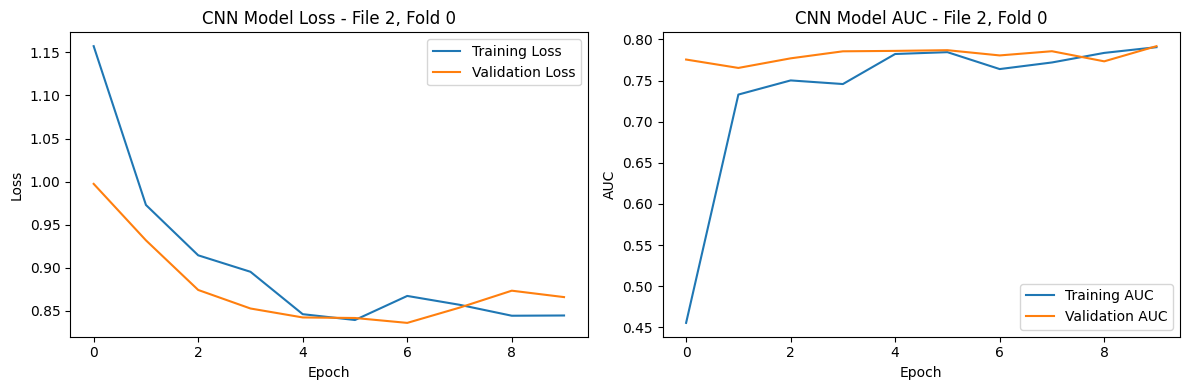

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Training File 2, Fold 1
Train shape: (196, 654, 10, 1), Val shape: (49, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 549ms/step - accuracy: 0.4673 - auc: 0.6344 - loss: 1.0777 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6939 - val_auc: 0.7653 - val_loss: 1.0107 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6681 - auc: 0.7360 - loss: 0.9749 - precision: 0.5138 - recall: 0.1136 - val_accuracy: 0.6939 - val_auc: 0.7770 - val_loss: 0.8979 - val_precision: 0.6939 - val_recall: 0.6939
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7039 - auc: 0.7623 - loss: 0.8799 - precision: 0.6973 - recall: 0.5782 - val_accuracy: 0.6939 - val_auc: 0.7856 - val_loss: 0.8345 - val_precision: 0.6939 - val_recall: 0.6939
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6978 - auc: 0.7511 - loss: 0.8703 - precision: 0.711

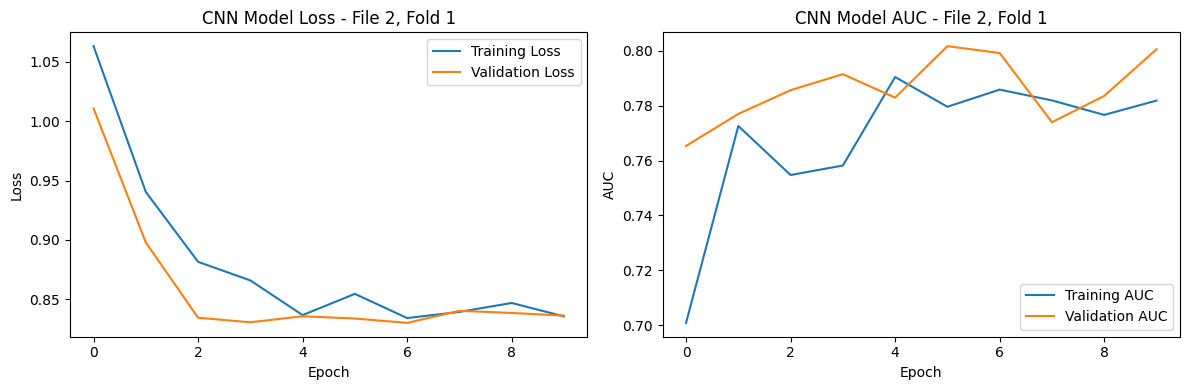

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Training File 2, Fold 2
Train shape: (196, 654, 10, 1), Val shape: (49, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 595ms/step - accuracy: 0.3125 - auc: 0.4927 - loss: 1.1103 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6939 - val_auc: 0.7653 - val_loss: 1.0487 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6851 - auc: 0.7805 - loss: 0.9844 - precision: 0.5685 - recall: 0.0150 - val_accuracy: 0.6939 - val_auc: 0.7703 - val_loss: 0.9730 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7045 - auc: 0.8027 - loss: 0.8833 - precision: 0.7704 - recall: 0.3976 - val_accuracy: 0.6939 - val_auc: 0.7865 - val_loss: 0.8736 - val_precision: 0.6939 - val_recall: 0.6939
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6790 - auc: 0.7690 - loss: 0.8776 - precisio

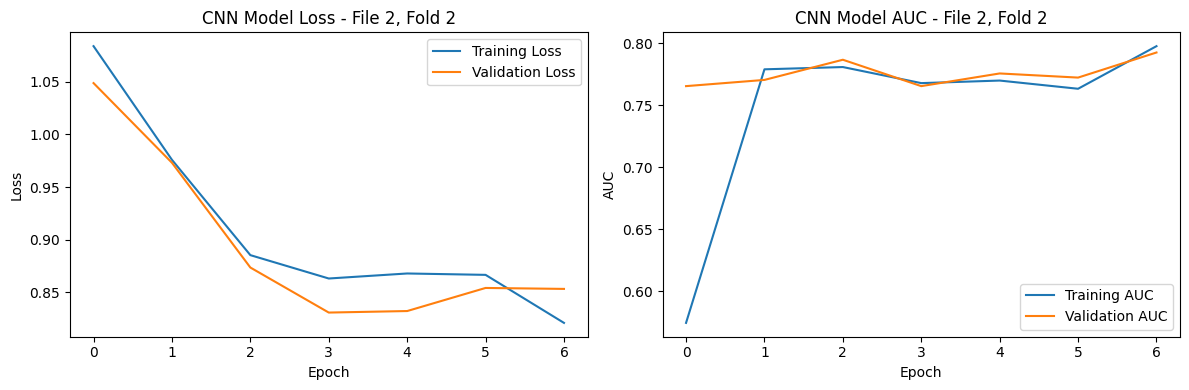

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Training File 2, Fold 3
Train shape: (196, 654, 10, 1), Val shape: (49, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 568ms/step - accuracy: 0.5406 - auc: 0.6650 - loss: 1.0773 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6939 - val_auc: 0.7551 - val_loss: 1.0290 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7101 - auc: 0.7805 - loss: 0.9840 - precision: 0.4823 - recall: 0.0362 - val_accuracy: 0.6939 - val_auc: 0.7551 - val_loss: 0.9314 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6969 - auc: 0.7435 - loss: 0.9099 - precision: 0.6583 - recall: 0.4548 - val_accuracy: 0.6939 - val_auc: 0.7792 - val_loss: 0.8463 - val_precision: 0.6939 - val_recall: 0.6939
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6942 - auc: 0.7786 - loss: 0.8481 - precisio

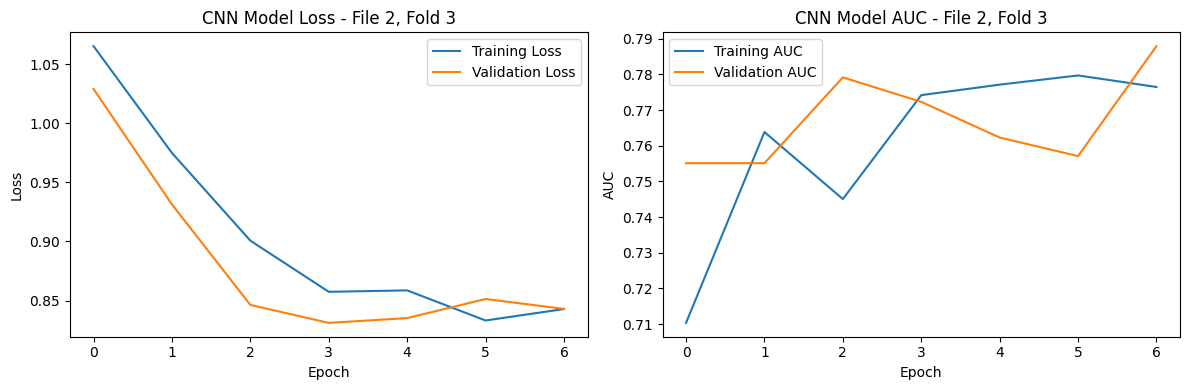

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Training File 2, Fold 4
Train shape: (196, 654, 10, 1), Val shape: (49, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - accuracy: 0.5375 - auc: 0.7009 - loss: 1.0504 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6939 - val_auc: 0.7567 - val_loss: 1.0048 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7283 - auc: 0.8064 - loss: 0.9311 - precision: 0.6971 - recall: 0.1499 - val_accuracy: 0.6939 - val_auc: 0.7551 - val_loss: 0.9189 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6560 - auc: 0.7426 - loss: 0.9203 - precision: 0.6798 - recall: 0.5135 - val_accuracy: 0.6939 - val_auc: 0.7686 - val_loss: 0.8468 - val_precision: 0.6939 - val_recall: 0.6939
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7026 - auc: 0.7707 - loss: 0.8525 - precisio

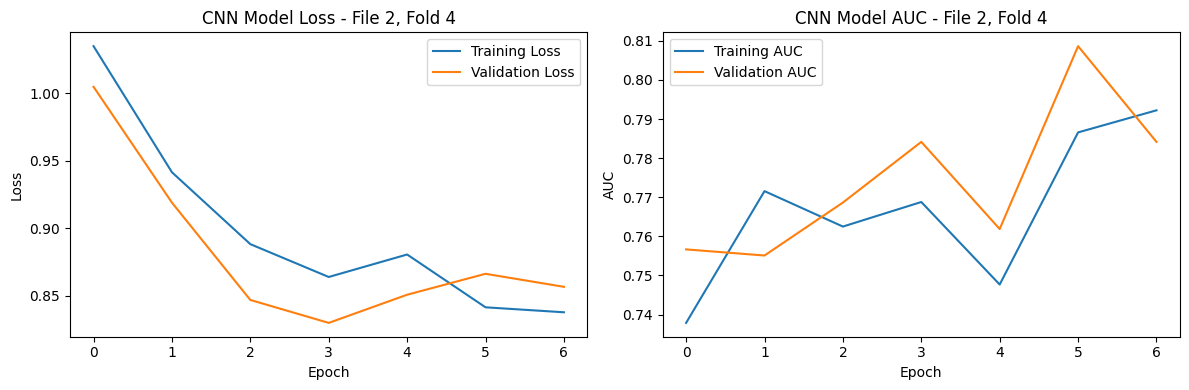

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Training File 3, Fold 0
Train shape: (267, 654, 10, 1), Val shape: (67, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.4807 - auc: 0.6505 - loss: 1.0632 - precision: 0.1389 - recall: 0.0017       

2025-08-19 00:28:18.294326: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 8 bytes spill stores, 8 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 575ms/step - accuracy: 0.4937 - auc: 0.6623 - loss: 1.0585 - precision: 0.2000 - recall: 0.0026 - val_accuracy: 0.7463 - val_auc: 0.8466 - val_loss: 0.9353 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7471 - auc: 0.7961 - loss: 0.8736 - precision: 0.6835 - recall: 0.3879 - val_accuracy: 0.7463 - val_auc: 0.8505 - val_loss: 0.7675 - val_precision: 0.7463 - val_recall: 0.7463
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7271 - auc: 0.8235 - loss: 0.7699 - precision: 0.7366 - recall: 0.7271 - val_accuracy: 0.7463 - val_auc: 0.8736 - val_loss: 0.7356 - val_precision: 0.7463 - val_recall: 0.7463
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7608 - auc: 0.8262 - loss: 0.7496 - precision: 0.7584 - recall: 0.7510 - val_accuracy: 0.7463 - val_auc: 0.8775 - val_loss: 0.7417 - val_precision: 0.7463 - val_recall: 0.7463
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14m

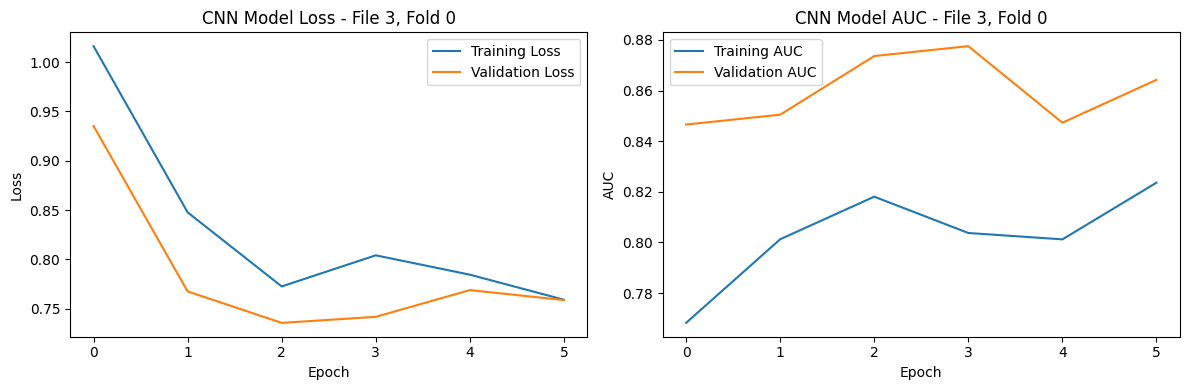

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
Training File 3, Fold 1
Train shape: (267, 654, 10, 1), Val shape: (67, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7095 - auc: 0.7838 - loss: 0.9761 - precision: 0.4385 - recall: 0.0572

2025-08-19 00:28:27.560808: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 8 bytes spill stores, 8 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - accuracy: 0.7124 - auc: 0.7870 - loss: 0.9711 - precision: 0.4705 - recall: 0.0691 - val_accuracy: 0.7463 - val_auc: 0.8449 - val_loss: 0.8507 - val_precision: 0.7463 - val_recall: 0.7463
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7167 - auc: 0.7923 - loss: 0.8207 - precision: 0.7166 - recall: 0.6778 - val_accuracy: 0.7463 - val_auc: 0.8577 - val_loss: 0.7408 - val_precision: 0.7463 - val_recall: 0.7463
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7542 - auc: 0.8212 - loss: 0.7617 - precision: 0.7511 - recall: 0.7414 - val_accuracy: 0.7463 - val_auc: 0.8619 - val_loss: 0.7422 - val_precision: 0.7463 - val_recall: 0.7463
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7697 - auc: 0.8271 - loss: 0.7230 - precision: 0.7694 - recall: 0.7686 - val_accuracy: 0.7463 - val_auc: 0.8387 - val_loss: 0.7765 - val_precision: 0.7463 - val_recall: 0.7463
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step -

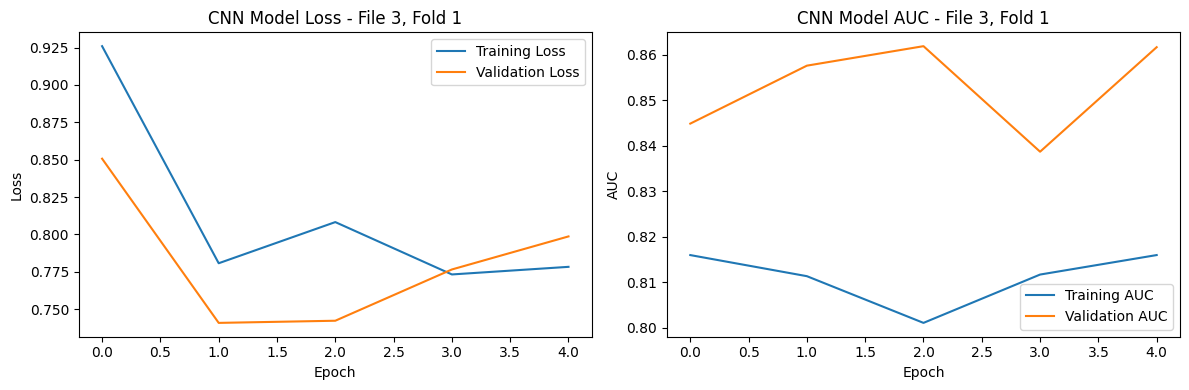

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step
Training File 3, Fold 2
Train shape: (267, 654, 10, 1), Val shape: (67, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3499 - auc: 0.5353 - loss: 1.0912 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-08-19 00:28:36.211785: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 8 bytes spill stores, 8 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - accuracy: 0.3655 - auc: 0.5478 - loss: 1.0885 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7313 - val_auc: 0.7930 - val_loss: 1.0014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7219 - auc: 0.7870 - loss: 0.9572 - precision: 0.6178 - recall: 0.0698 - val_accuracy: 0.7313 - val_auc: 0.8133 - val_loss: 0.8877 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7374 - auc: 0.8200 - loss: 0.8212 - precision: 0.7636 - recall: 0.6025 - val_accuracy: 0.7313 - val_auc: 0.8124 - val_loss: 0.7873 - val_precision: 0.7313 - val_recall: 0.7313
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7419 - auc: 0.7977 - loss: 0.7986 - precision: 0.7366 - recall: 0.7207 - val_accuracy: 0.7313 - val_auc: 0.8418 - val_loss: 0.7696 - val_precision: 0.7313 - val_recall: 0.7313
Epoch 5/100
9/9 ━━━━━━━━━━━

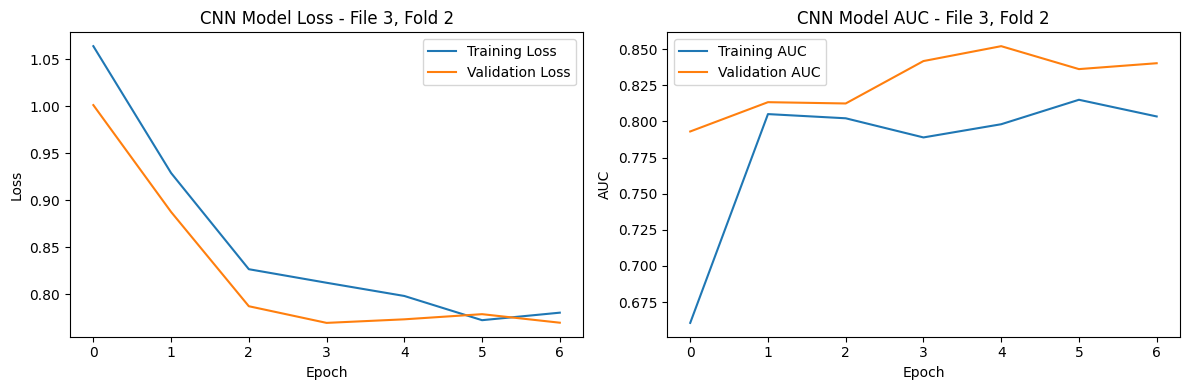

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Training File 3, Fold 3
Train shape: (267, 654, 10, 1), Val shape: (67, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.5514 - auc: 0.7309 - loss: 1.0500 - precision: 0.0556 - recall: 4.1615e-04   

2025-08-19 00:28:44.510850: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion', 8 bytes spill stores, 8 bytes spill loads



9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 414ms/step - accuracy: 0.5600 - auc: 0.7359 - loss: 1.0473 - precision: 0.1000 - recall: 7.4906e-04 - val_accuracy: 0.7313 - val_auc: 0.8139 - val_loss: 0.9717 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7472 - auc: 0.7865 - loss: 0.8986 - precision: 0.6921 - recall: 0.2773 - val_accuracy: 0.7313 - val_auc: 0.8577 - val_loss: 0.8058 - val_precision: 0.7313 - val_recall: 0.7313
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7539 - auc: 0.8205 - loss: 0.7515 - precision: 0.7506 - recall: 0.7373 - val_accuracy: 0.7313 - val_auc: 0.8742 - val_loss: 0.7654 - val_precision: 0.7313 - val_recall: 0.7313
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7544 - auc: 0.8388 - loss: 0.7271 - precision: 0.7544 - recall: 0.7544 - val_accuracy: 0.7313 - val_auc: 0.8504 - val_loss: 0.7746 - val_precision: 0.7313 - val_recall: 0.7313
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s

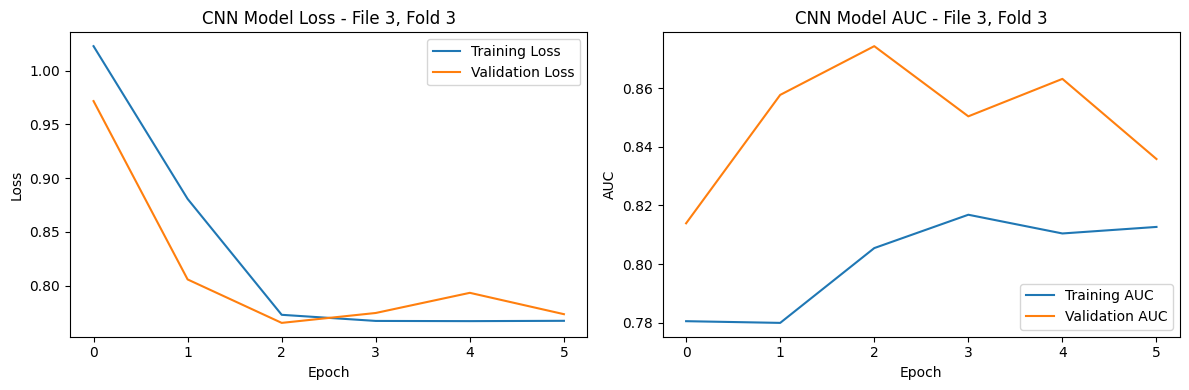

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Training File 3, Fold 4
Train shape: (268, 654, 10, 1), Val shape: (66, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 535ms/step - accuracy: 0.3838 - auc: 0.5549 - loss: 1.0911 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7424 - val_auc: 0.8122 - val_loss: 1.0085 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7313 - auc: 0.7921 - loss: 0.9342 - precision: 0.6192 - recall: 0.1169 - val_accuracy: 0.7424 - val_auc: 0.8277 - val_loss: 0.8265 - val_precision: 0.7424 - val_recall: 0.7424
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7360 - auc: 0.8128 - loss: 0.7878 - precision: 0.7372 - recall: 0.7138 - val_accuracy: 0.7424 - val_auc: 0.8486 - val_loss: 0.7485 - val_precision: 0.7424 - val_recall: 0.7424
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7496 - auc: 0.8221 - loss: 0.7647 - precision: 0.748

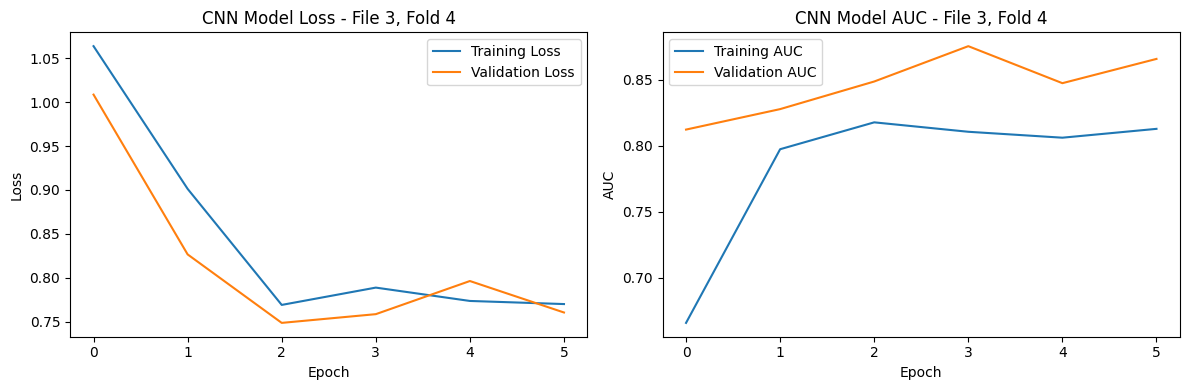

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
Training File 4, Fold 0
Train shape: (264, 654, 10, 1), Val shape: (67, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.4357 - auc: 0.6031 - loss: 1.0709 - precision: 0.4125 - recall: 0.0112 - val_accuracy: 0.7015 - val_auc: 0.7612 - val_loss: 0.9532 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7425 - auc: 0.7904 - loss: 0.8719 - precision: 0.7330 - recall: 0.4883 - val_accuracy: 0.7015 - val_auc: 0.7612 - val_loss: 0.8346 - val_precision: 0.7015 - val_recall: 0.7015
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7352 - auc: 0.7694 - loss: 0.8444 - precision: 0.7303 - recall: 0.7033 - val_accuracy: 0.7015 - val_auc: 0.7910 - val_loss: 0.8293 - val_precision: 0.7015 - val_recall: 0.7015
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7226 - auc: 0.7911 - loss: 0.8160 - precision: 0.7236 - reca

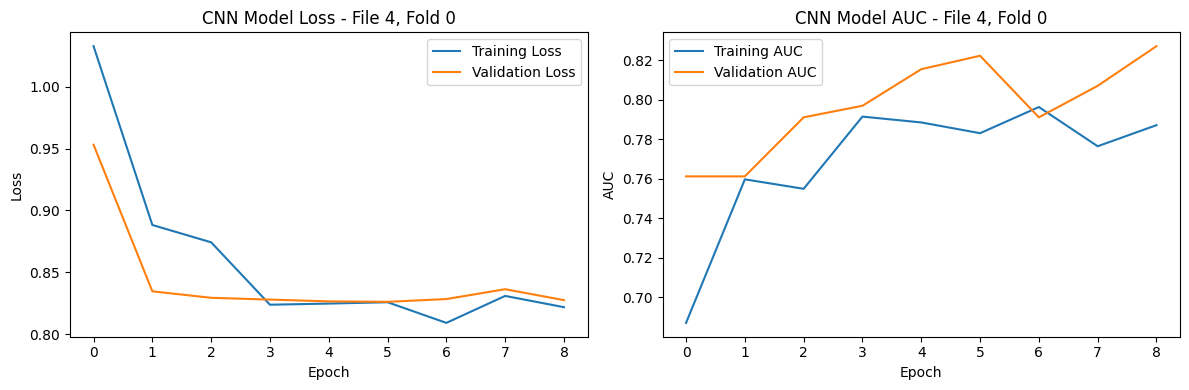

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Training File 4, Fold 1
Train shape: (265, 654, 10, 1), Val shape: (66, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 514ms/step - accuracy: 0.5045 - auc: 0.6575 - loss: 1.0602 - precision: 0.2100 - recall: 0.0034 - val_accuracy: 0.7121 - val_auc: 0.7965 - val_loss: 0.9535 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7073 - auc: 0.7811 - loss: 0.8893 - precision: 0.7020 - recall: 0.4129 - val_accuracy: 0.7121 - val_auc: 0.7967 - val_loss: 0.8059 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7079 - auc: 0.7868 - loss: 0.8353 - precision: 0.7079 - recall: 0.7079 - val_accuracy: 0.7121 - val_auc: 0.8097 - val_loss: 0.8030 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7088 - auc: 0.8008 - loss: 0.8150 - precision: 0.7032 - reca

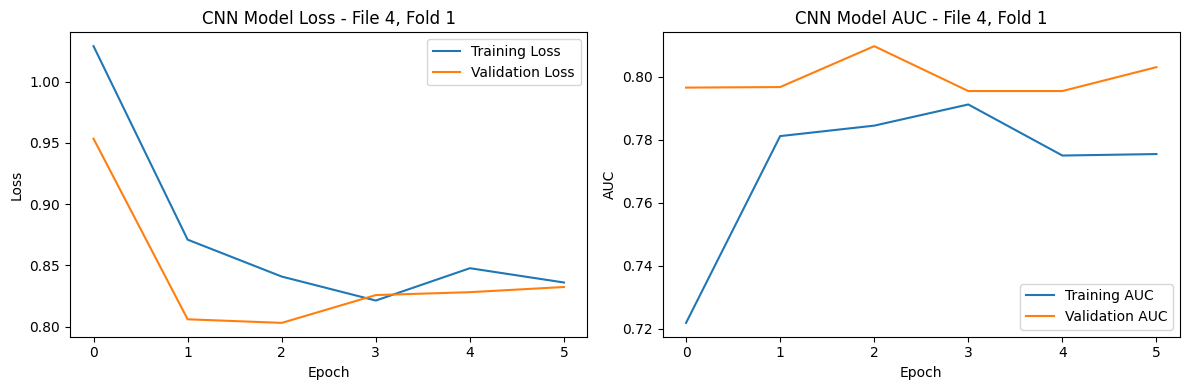

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step
Training File 4, Fold 2
Train shape: (265, 654, 10, 1), Val shape: (66, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.4186 - auc: 0.6693 - loss: 1.0391 - precision: 0.3117 - recall: 0.0083 - val_accuracy: 0.7121 - val_auc: 0.7948 - val_loss: 0.9452 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7123 - auc: 0.7865 - loss: 0.8901 - precision: 0.6774 - recall: 0.3829 - val_accuracy: 0.7121 - val_auc: 0.8046 - val_loss: 0.8182 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7085 - auc: 0.7596 - loss: 0.8726 - precision: 0.7118 - recall: 0.6773 - val_accuracy: 0.7121 - val_auc: 0.8256 - val_loss: 0.7990 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7233 - auc: 0.7938 - loss: 0.8112 - precision: 0.7233 - reca

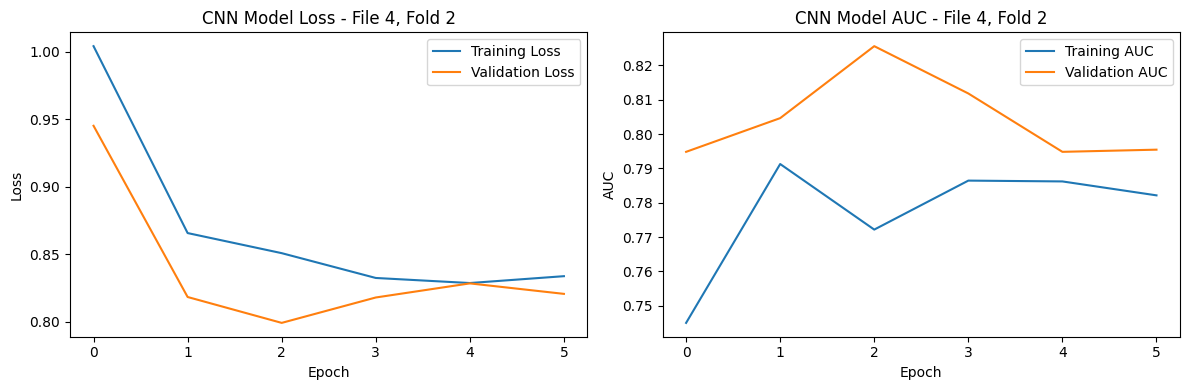

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Training File 4, Fold 3
Train shape: (265, 654, 10, 1), Val shape: (66, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.5198 - auc: 0.7278 - loss: 0.9656 - precision: 0.6557 - recall: 0.1984 - val_accuracy: 0.7121 - val_auc: 0.7955 - val_loss: 0.8614 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7389 - auc: 0.8023 - loss: 0.8134 - precision: 0.7380 - recall: 0.7087 - val_accuracy: 0.7121 - val_auc: 0.8092 - val_loss: 0.8085 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7030 - auc: 0.8114 - loss: 0.8123 - precision: 0.7149 - recall: 0.6906 - val_accuracy: 0.7121 - val_auc: 0.8165 - val_loss: 0.8288 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6923 - auc: 0.7992 - loss: 0.8252 - precision: 0.6992 - recall: 0.66

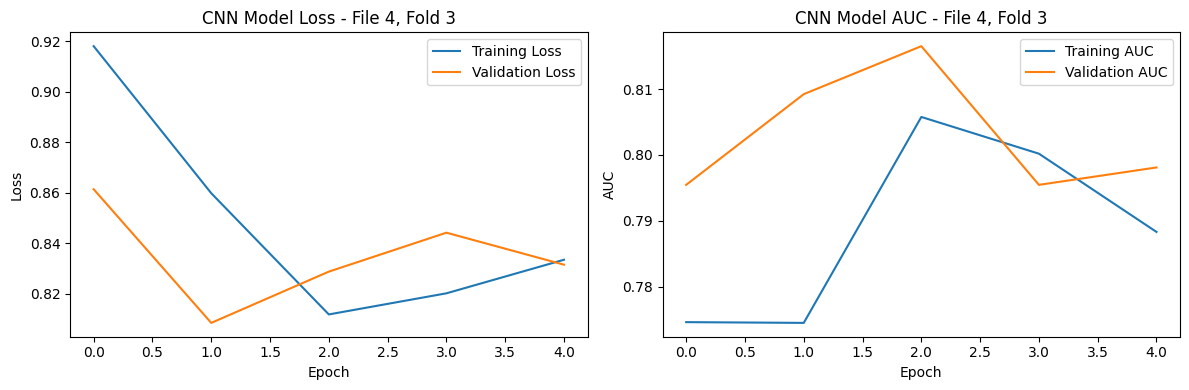

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Training File 4, Fold 4
Train shape: (265, 654, 10, 1), Val shape: (66, 654, 10, 1)
Model parameters: 7,203
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - accuracy: 0.4273 - auc: 0.5952 - loss: 1.0824 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7121 - val_auc: 0.7727 - val_loss: 1.0106 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6917 - auc: 0.7695 - loss: 0.9594 - precision: 0.6970 - recall: 0.1178 - val_accuracy: 0.7121 - val_auc: 0.7955 - val_loss: 0.8894 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7034 - auc: 0.7948 - loss: 0.8364 - precision: 0.7216 - recall: 0.6605 - val_accuracy: 0.7121 - val_auc: 0.8169 - val_loss: 0.8025 - val_precision: 0.7121 - val_recall: 0.7121
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7437 - auc: 0.8064 - loss: 0.7852 - precision: 0.742

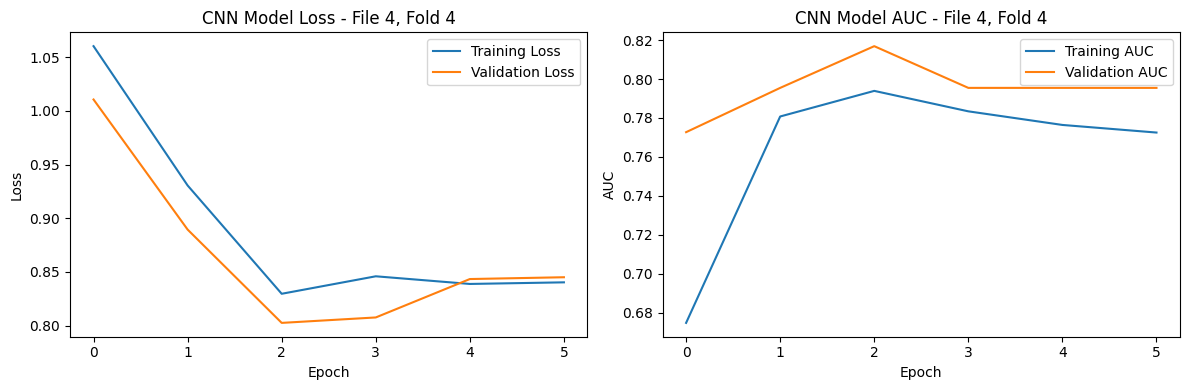

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


In [5]:
# Cross-validation using stratified k-Fold masks
n_folds = len(all_masks[0])
results = []

for file_idx, (X, y, masks) in enumerate(zip(all_X, all_y, all_masks)):
    file_results = []
    n_classes = len(np.unique(y))
    
    for fold_idx, val_mask in enumerate(masks):
        train_mask = ~val_mask
        X_train, y_train = X[train_mask], y[train_mask]
        X_val, y_val = X[val_mask], y[val_mask]

        # Normalize pixel values to [0, 1] range (CNN images are already normalized during preprocessing)
        # No additional scaling needed for CNN input

        # One-hot encode labels for keras if multiclass
        if len(np.unique(y_train)) > 2:
            # Create mapping from original labels to consecutive indices
            unique_labels = sorted(np.unique(y_train))
            label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
            idx_to_label = {idx: label for label, idx in label_to_idx.items()}
            
            # Map labels to consecutive indices
            y_train_mapped = np.array([label_to_idx[label] for label in y_train])
            y_val_mapped = np.array([label_to_idx[label] for label in y_val])
            
            n_classes = len(unique_labels)
            y_train_cat = keras.utils.to_categorical(y_train_mapped, num_classes=n_classes)
            y_val_cat = keras.utils.to_categorical(y_val_mapped, num_classes=n_classes)
            loss_fn = "categorical_crossentropy"
            activation = "softmax"
        else:
            y_train_cat = y_train
            y_val_cat = y_val
            n_classes = 2
            loss_fn = "binary_crossentropy"
            activation = "sigmoid"

        # Build CNN model
        model = keras.Sequential()
        model.add(layers.Input(shape=X_train.shape[1:]))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal"))

        # Convolution first block
        model.add(layers.Conv2D(16, (5, 3), padding='same'))
        model.add(layers.LeakyReLU(negative_slope=0.01))
        model.add(layers.MaxPooling2D((2, 1)))
        model.add(layers.Dropout(0.3))  

        # Convolution second block
        model.add(layers.Conv2D(32, (3, 3), padding='same'))  
        model.add(layers.LeakyReLU(negative_slope=0.01))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.4))

        # Dense layers
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(64))  
        model.add(layers.LeakyReLU(negative_slope=0.01))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(n_classes if n_classes > 2 else 1, activation=activation))

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3), 
            loss=loss_fn,
            metrics=["accuracy", "precision", "recall", AUC(name='auc')]
        )

        print(f"Training File {file_idx}, Fold {fold_idx}")
        print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")
        print(f"Model parameters: {model.count_params():,}")

        # Train model with Early Stopping; store history
        history = model.fit(
            X_train, y_train_cat,
            epochs=100,
            batch_size=32,  # Smaller batch size for CNN
            verbose=1,
            validation_data=(X_val, y_val_cat),
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                # ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
            ]
        )

        # Plot learning curves for this fold
        plt.figure(figsize=(12, 4))
        
        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'CNN Model Loss - File {file_idx}, Fold {fold_idx}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot AUC
        plt.subplot(1, 2, 2)
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.title(f'CNN Model AUC - File {file_idx}, Fold {fold_idx}')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

        # Predict
        if n_classes > 2:
            y_pred_proba = model.predict(X_val)
            y_pred_idx = np.argmax(y_pred_proba, axis=1)
            # Map back to original labels
            y_pred_class = np.array([idx_to_label[idx] for idx in y_pred_idx])
        else:
            y_pred_proba = model.predict(X_val).flatten()
            y_pred_class = (y_pred_proba > 0.5).astype(int)

        # Metrics
        avg = 'weighted'
        try:
            if n_classes > 2:
                roc_auc = roc_auc_score(y_val, y_pred_proba, multi_class='ovr', average='weighted')
            else:
                roc_auc = roc_auc_score(y_val, y_pred_proba)
        except Exception:
            roc_auc = np.nan

        metrics = {
            "accuracy": accuracy_score(y_val, y_pred_class),
            "precision": precision_score(y_val, y_pred_class, average=avg, zero_division=0),
            "recall": recall_score(y_val, y_pred_class, average=avg, zero_division=0),
            "f1": f1_score(y_val, y_pred_class, average=avg, zero_division=0),
            "roc_auc": roc_auc,
            "confusion_matrix": confusion_matrix(y_val, y_pred_class, labels=sorted(np.unique(y))).tolist(),
            "fold": fold_idx,
            "file": selected_files[file_idx],
        }
        file_results.append(metrics)
    results.extend(file_results)

                                                    accuracy  precision  \
file                                                                      
221111_144114__binary_onlylines114378to117271 l...  0.637931   0.406956   
221111_144114__binary_onlylines145900to148050 l...  0.703700   0.495275   
221111_144114__binary_onlylines25660to28100 loe...  0.693878   0.481466   
221111_144114__binary_onlylines47178to50517 loe...  0.739530   0.546951   
221111_144114__binary_onlylines86841to90142 loe...  0.709995   0.504112   

                                                      recall        f1  \
file                                                                     
221111_144114__binary_onlylines114378to117271 l...  0.637931  0.496915   
221111_144114__binary_onlylines145900to148050 l...  0.703700  0.581348   
221111_144114__binary_onlylines25660to28100 loe...  0.693878  0.568478   
221111_144114__binary_onlylines47178to50517 loe...  0.739530  0.628813   
221111_144114__binary_onlyline

/tmp/ipykernel_99362/4263751104.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


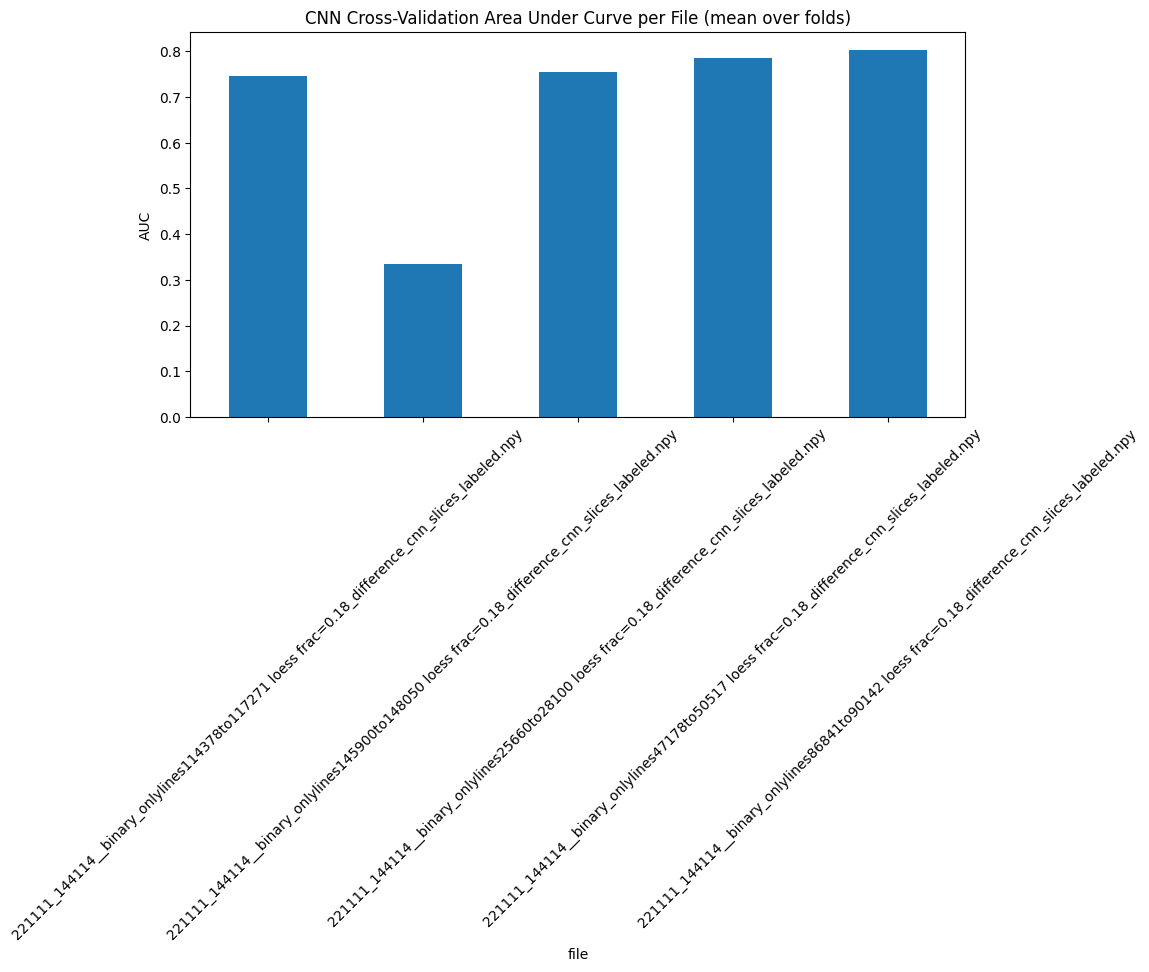

In [6]:
# Summarize results
df = pd.DataFrame(results)
print(df.groupby("file")[["accuracy", "precision", "recall", "f1", "roc_auc"]].mean())

# Optional: plot AUC per file
df.groupby("file")["roc_auc"].mean().plot.bar(rot=45, figsize=(10, 5))
plt.title("CNN Cross-Validation Area Under Curve per File (mean over folds)")
plt.ylabel("AUC")
plt.tight_layout()
plt.show()

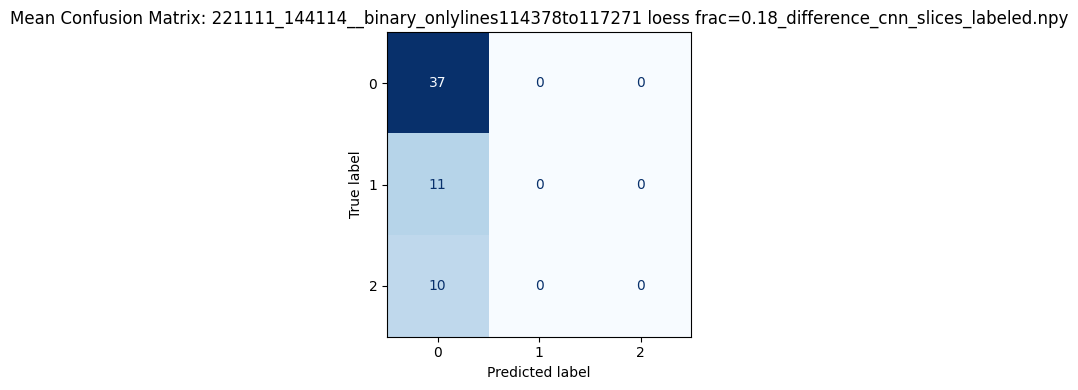

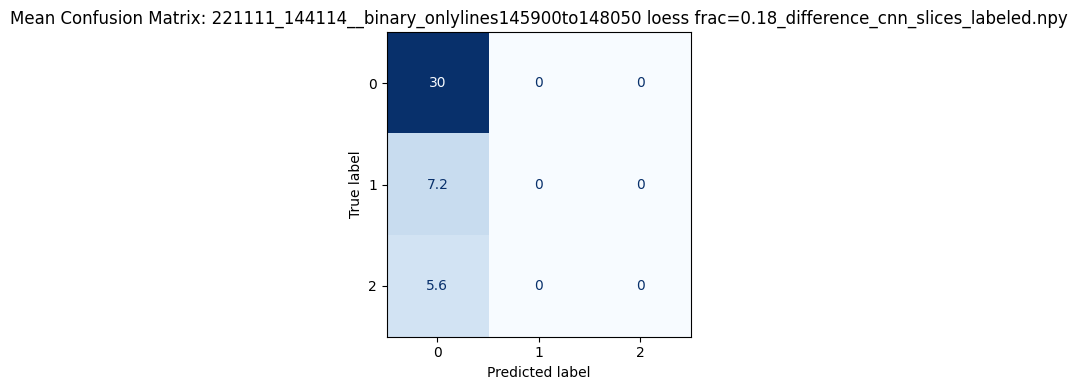

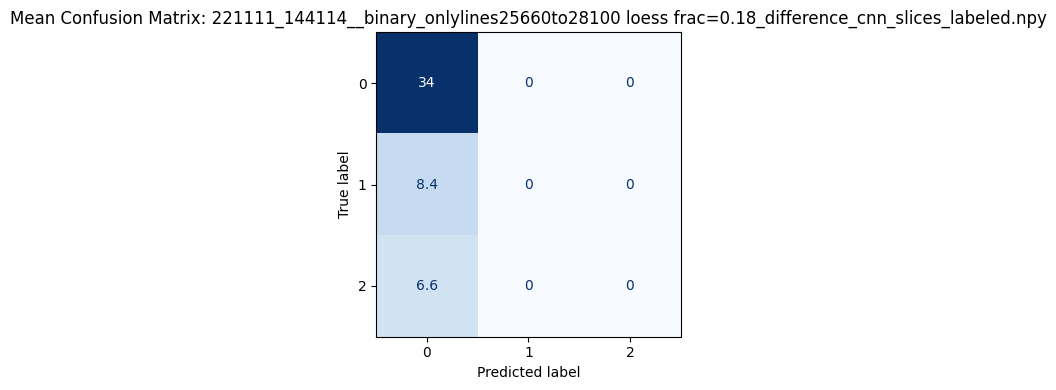

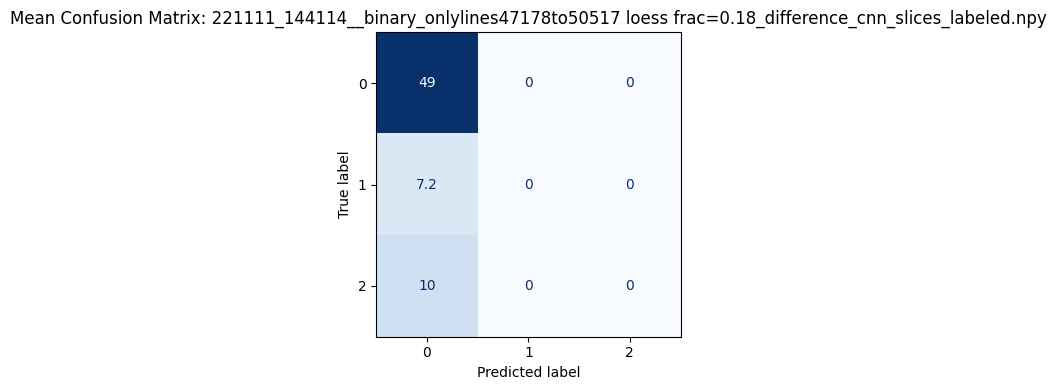

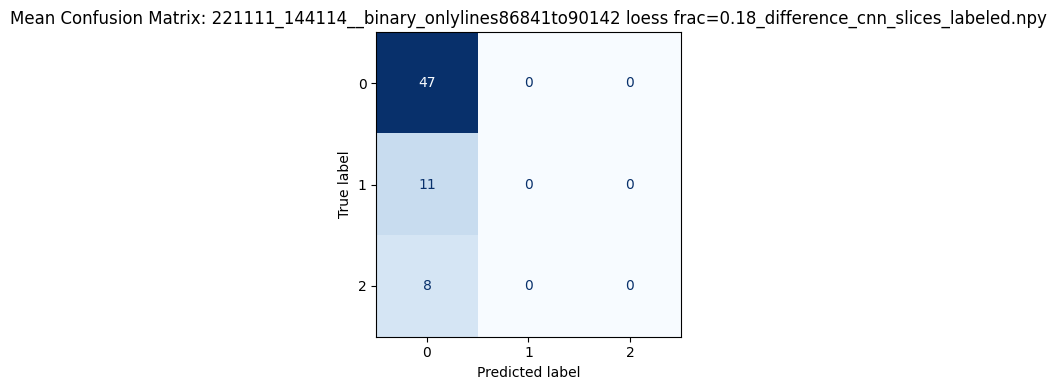

In [7]:
# Show confusion matrix for each file (mean over folds)
from sklearn.metrics import ConfusionMatrixDisplay

for file in df["file"].unique():
    cms = [np.array(row) for row in df[df["file"] == file]["confusion_matrix"]]
    # Find the largest shape
    max_dim = max(cm.shape[0] for cm in cms)
    # Pad all confusion matrices to max_dim x max_dim
    padded = []
    for cm in cms:
        pad_width = ((0, max_dim - cm.shape[0]), (0, max_dim - cm.shape[1]))
        padded.append(np.pad(cm, pad_width, mode='constant'))
    mean_cm = np.mean(padded, axis=0)
    display_labels = [str(l) for l in range(max_dim)]
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(mean_cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(f"Mean Confusion Matrix: {file}")
    plt.tight_layout()
    plt.show()